# Guided Test Case Generation System Notebook

In [81]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from sklearn.utils import shuffle


### Read Data

In [82]:
df = pd.read_csv('training_data/wav2letter.txt', sep=",", header=None)
df.columns = ["sentence", "label"]
df = shuffle(df)
df = df.reset_index(drop=True)

BUG_LABEL = 1
NON_BUG_LABEL = 0

In [83]:
df.groupby("label").describe()

sentence                                                                
         count  unique                                                top freq
label                                                                         
0       178277  177465   not written in the book of the chronicles of the   11
1         1857    1856  ladies and gentlemen i am ordered by miss wood...    2

### Data distribution

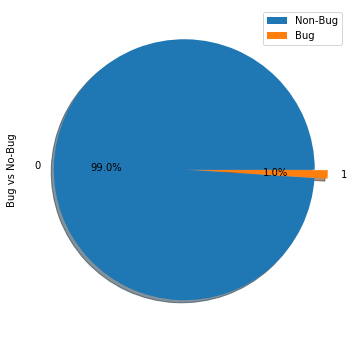

In [84]:
df["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Bug vs No-Bug")
plt.legend(["Non-Bug", "Bug"])
plt.show()

we need to handle imbalance data

## Experiment

In [85]:
FIRST_BATCH_SIZE = 15000
BATCH_SIZE = 1000
MAX_SIZE = len(df["label"])

data = df[:FIRST_BATCH_SIZE].copy()

### Handle Imbalance Data

Upsample the small data

In [86]:
from sklearn.utils import resample

def upsampleImbalanceData(df):
    # Separate majority and minority classes
    df_majority = df[df.label==NON_BUG_LABEL]
    df_minority = df[df.label==BUG_LABEL]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    df_upsampled.label.value_counts()

    return df_upsampled.copy()

### Feature Extraction

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Text processing: remove punction
def text_process(sentence):
    nopunc =[char for char in sentence if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split()]

In [88]:
# bag of words
corpus_sentence = pd.read_csv('corpus-sentence.txt', sep=",", header=None)
corpus_sentence.columns = ["sentence"]
bow_transformer = CountVectorizer(analyzer=text_process).fit(corpus_sentence["sentence"])

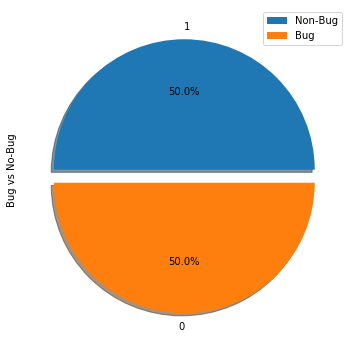

In [89]:
data = upsampleImbalanceData(data)
data["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Bug vs No-Bug")
plt.legend(["Non-Bug", "Bug"])
plt.show()

In [90]:
features = bow_transformer.transform(data["sentence"])
# print(sentence_bow)
# tfidf_transformer=TfidfTransformer().fit(sentence_bow)
# features = tfidf_transformer.transform(sentence_bow)
labels = data["label"]

### Trying Model in the First Batch

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [92]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=10)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=31, random_state=111)
bc = BaggingClassifier(n_estimators=10, random_state=111)
etc = ExtraTreesClassifier(n_estimators=10, random_state=111)

In [112]:
# clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}
clfs = {'SVC' : svc, 'NB': mnb, 'AdaBoost': abc, 'BgC': bc}
# clfs = {'AdaBoost': abc}

In [113]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
    
def predict_labels(clf, features):
    return (clf.predict(features))

In [114]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features, labels)
    pred = predict_labels(v,features)
    print("Classifier: " + k)
    print(classification_report(labels, pred))

Classifier: SVC
              precision    recall  f1-score   support

           0       0.53      0.53      0.53     14847
           1       0.53      0.53      0.53     14847

    accuracy                           0.53     29694
   macro avg       0.53      0.53      0.53     29694
weighted avg       0.53      0.53      0.53     29694

Classifier: NB
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     14847
           1       0.96      1.00      0.98     14847

    accuracy                           0.98     29694
   macro avg       0.98      0.98      0.98     29694
weighted avg       0.98      0.98      0.98     29694

Classifier: AdaBoost
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     14847
           1       0.81      0.74      0.77     14847

    accuracy                           0.78     29694
   macro avg       0.78      0.78      0.78     29694
weighted avg       0.7

### Trying Model for the Next Batch until Finish

In [115]:
MAX_SIZE = 20000

# classify the selected data
for k,v in clfs.items():
    lower_bound = FIRST_BATCH_SIZE
    training_data = df[:FIRST_BATCH_SIZE].copy()
    
    print("Classifier: " + k) 
    
    columns = ["Precision", "Recall", "F1-Score", "Predicted", "CorrectlyPredicted"]
    index = []
    performance_data = []
    
    
    while (lower_bound < MAX_SIZE) :
        # set the upper bound size
        upper_bound = lower_bound + BATCH_SIZE
        if (upper_bound > MAX_SIZE) :
            upper_bound = MAX_SIZE

        # get the data to be selected
        current_data = df[lower_bound:upper_bound].copy()
        current_sentence = current_data["sentence"]
        current_labels = current_data["label"]

        # extract feature from the data
        current_features = bow_transformer.transform(current_sentence)
    
        # predict the current data
        pred = predict_labels(v,current_features)
        
        # see the classifier performance
        unused_index = np.where(pred == NON_BUG_LABEL)
        used_index = np.where(pred == BUG_LABEL)
        bug_index = np.where(current_labels == BUG_LABEL)
        non_bug_index = np.where(current_labels == NON_BUG_LABEL)
        
        correctly_predicted_test_case = np.intersect1d(used_index, bug_index)
        missing_potential_test_case = np.intersect1d(unused_index, bug_index)
        
        batch = str(lower_bound) + " - " + str(upper_bound)
        precision = precision_score(current_labels, pred)
        recall = recall_score(current_labels, pred)
        f1 = f1_score(current_labels, pred)
        index.append(batch)
        performance_data.append([precision, recall, f1, len(used_index[0]), len(correctly_predicted_test_case)])
    
        # add the predicted data to previous data
        if (len(correctly_predicted_test_case) > 0) :
            added_data = current_data.iloc[correctly_predicted_test_case,:]
            training_data.append(added_data)

            # handle imbalance data
            training_data = upsampleImbalanceData(training_data)

            # re-extract feature
            features = bow_transformer.transform(training_data["sentence"])
            labels = training_data["label"]

            # re-train the model 
            train_classifier(v, features, labels)
        
        # update the lower bound
        lower_bound = upper_bound
    
    performance = pd.DataFrame(performance_data, index=index, columns=columns)
    print(performance)
    print("Total Generated: " + str(int(performance["Predicted"].sum(axis=0))))
    print("Total Bug: " + str(int(performance["CorrectlyPredicted"].sum(axis=0))))
    print("\n")
    

Classifier: SVC
               Precision    Recall  F1-Score  Predicted  CorrectlyPredicted
15000 - 16000   0.008529  0.500000  0.016771        469                   4
16000 - 17000   0.012320  0.666667  0.024194        487                   6
17000 - 18000   0.010101  0.714286  0.019920        495                   5
18000 - 19000   0.016327  0.666667  0.031873        490                   8
19000 - 20000   0.006608  0.750000  0.013100        454                   3
Total Generated: 2395
Total Bug: 26


Classifier: NB
               Precision    Recall  F1-Score  Predicted  CorrectlyPredicted
15000 - 16000   0.000000  0.000000  0.000000         39                   0
16000 - 17000   0.019608  0.111111  0.033333         51                   1
17000 - 18000   0.000000  0.000000  0.000000         67                   0
18000 - 19000   0.050000  0.166667  0.076923         40                   2
19000 - 20000   0.027027  0.250000  0.048780         37                   1
Total Generated: 23